In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# train.csv

In [3]:
train_csv = pd.read_csv('train.csv')
train_csv.shape

(3147, 15)

In [4]:
train_csv.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


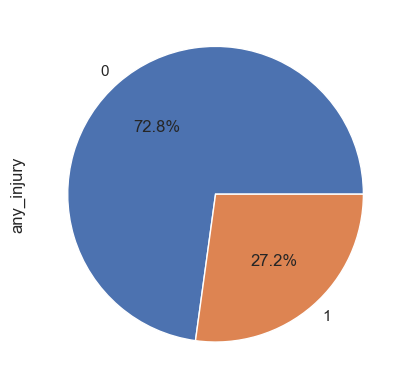

In [10]:
temp = train_csv['any_injury'].value_counts()
temp.plot(kind='pie', autopct='%1.1f%%')
plt.show()

spleen is the most unhealthy

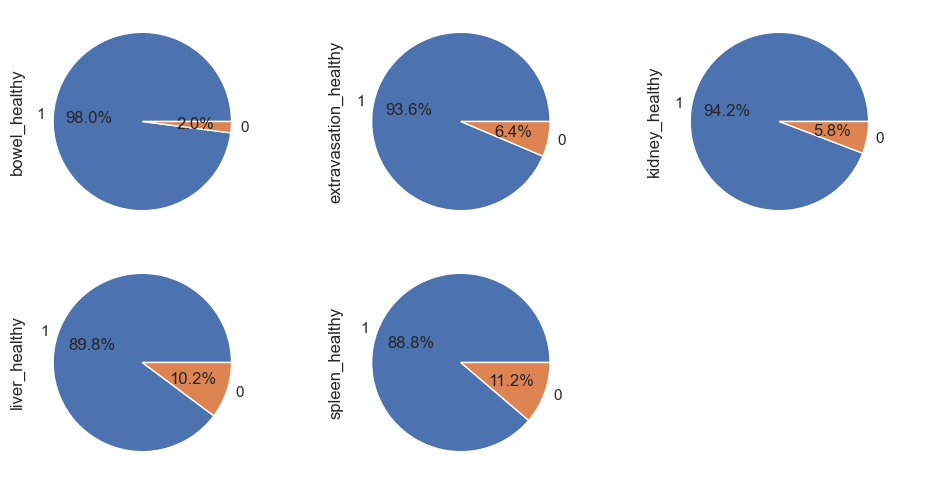

In [18]:
_, ax = plt.subplots(2, 3, figsize=(10, 5))
num_image = 0
for col in train_csv.columns:
    if col.endswith('_healthy'):
        row = num_image//3
        cols = num_image % 3
        temp = train_csv[col].value_counts()
        temp.plot(kind='pie', autopct='%1.1f%%',
                  ax=ax[row, cols])
        num_image += 1
ax[1, 2].axis('off')
plt.tight_layout()
plt.show()

# train_series_meta.csv
- summary: the "aortic_hu" value can be used as an indicator of the timing of the CT scan. In a multiphasic CT scan, a higher "aortic_hu" value suggests that the scan was taken during the late arterial phase, when the aorta is most enhanced with contrast due to the complete circulation of contrast-enhanced blood. This can be valuable information for accurately interpreting the scan and understanding the contrast dynamics within the body.

- the "aortic_hu" value is being used as a way to estimate the timing of the CT scan. This is because the density of the aorta can change depending on the phase of contrast enhancement during the scan.
- A multiphasic CT scan involves taking images of the same area of the body at different time points after the injection of a contrast dye. The contrast dye helps visualize blood vessels and other structures more clearly.
- During a multiphasic CT scan, different phases are captured based on the timing of the contrast injection. The "late arterial phase" refers to a specific point in time after the contrast injection when the contrast has fully flowed through the blood vessels, including the aorta. The aorta is most enhanced during this phase due to the high blood flow.

In [34]:
train_series_meta = pd.read_csv('train_series_meta.csv')
print(f'train_series_meta.shape: {train_series_meta.shape}')
train_series_meta.head()


train_series_meta.shape: (4711, 4)


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


### Incompletely scanned organs
There are 313 training images with incompletely scanned organ, should we remove them?

Number of patients with complete organs: 0
Number of patients with incomplete organs: 4711


Text(0, 0.5, 'Count')

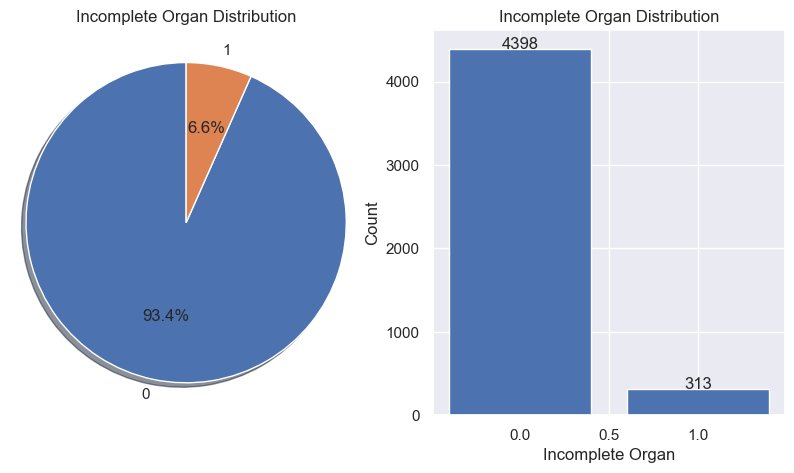

In [48]:
# print counts
incomplete_organ_count = train_series_meta['incomplete_organ'].value_counts()
# incomplete_organ_count = train_series_meta.groupby('incomplete_organ').count()['patient_id'].sort_values(ascending=False) # more flexible approach

print(f'Number of patients with complete organs: {train_series_meta.shape[0] - incomplete_organ_count.sum()}')
print(f'Number of patients with incomplete organs: {incomplete_organ_count.sum()}')

# create subplots, one is pie chart, the other is bar chart
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# pie chart
ax[0].pie(incomplete_organ_count, labels=incomplete_organ_count.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Incomplete Organ Distribution')

# bar chart
ax[1].bar(incomplete_organ_count.index, incomplete_organ_count)
# show the count on top of each bar
for i, v in enumerate(incomplete_organ_count):
    ax[1].text(i, v + 0.5, str(v), ha='center')

ax[1].set_title('Incomplete Organ Distribution')
ax[1].set_xlabel('Incomplete Organ')
ax[1].set_ylabel('Count')


## Aortic HU

Plot the histogram and boxplot of Aortic HU

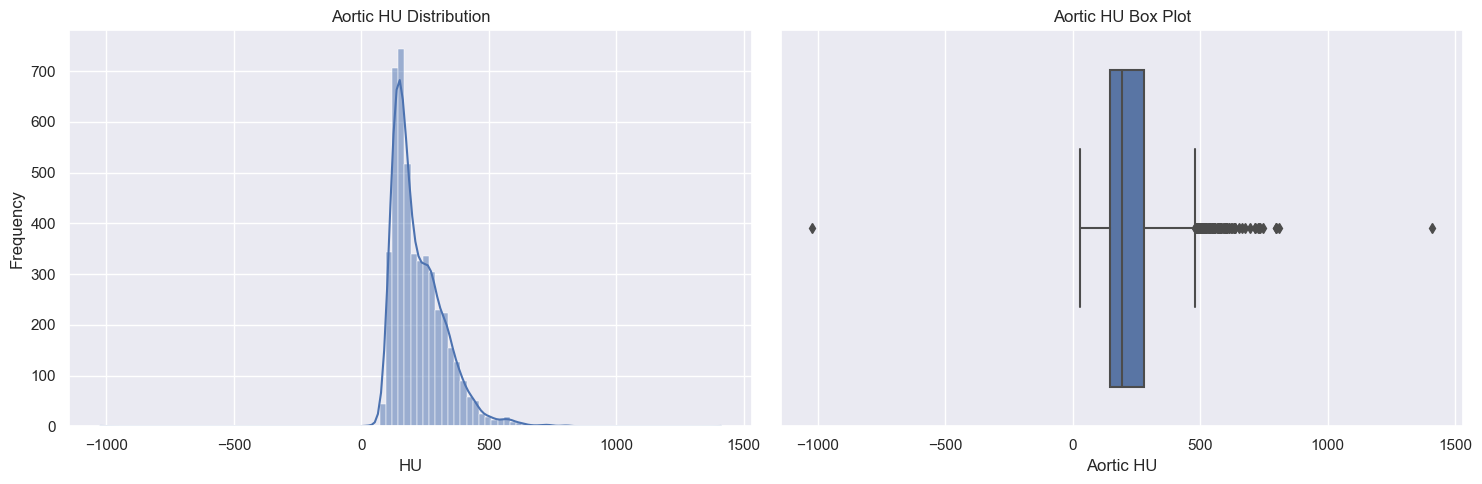

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histogram with KDE
sns.histplot(data=train_series_meta, x="aortic_hu", kde=True, bins=100, ax=axs[0])
axs[0].set_title('Aortic HU Distribution')
axs[0].set_xlabel('HU')
axs[0].set_ylabel('Frequency')

# Subplot 2: Box Plot
sns.boxplot(x='aortic_hu', data=train_series_meta, ax=axs[1])
axs[1].set_title('Aortic HU Box Plot')
axs[1].set_xlabel('Aortic HU')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

Remove the outliers

In [68]:
# Calculate z-scores for the 'aortic_hu' column
z_scores = np.abs((train_series_meta['aortic_hu'] - train_series_meta['aortic_hu'].mean()) / train_series_meta['aortic_hu'].std())

# Define a z-score threshold beyond which data p
# oints are considered outliers
z_score_threshold = 3.0

# Create a new DataFrame without outliers
train_series_meta_clean = train_series_meta[z_scores <= z_score_threshold]


Plot the histogram and boxplot of Aortic HU

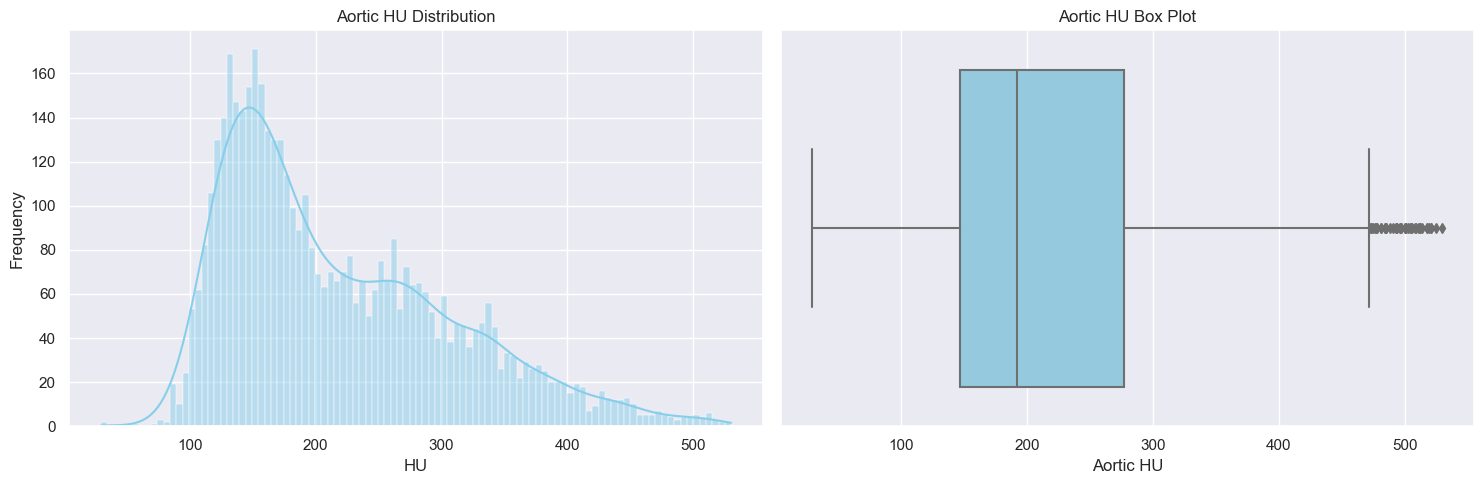

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Subplot 1: Histogram with KDE
sns.histplot(data=train_series_meta_clean, x="aortic_hu", kde=True, bins=100, ax=axs[0], color='skyblue')
axs[0].set_title('Aortic HU Distribution')
axs[0].set_xlabel('HU')
axs[0].set_ylabel('Frequency')

# Subplot 2: Box Plot
sns.boxplot(x='aortic_hu', data=train_series_meta_clean, ax=axs[1], color='skyblue')
axs[1].set_title('Aortic HU Box Plot')
axs[1].set_xlabel('Aortic HU')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

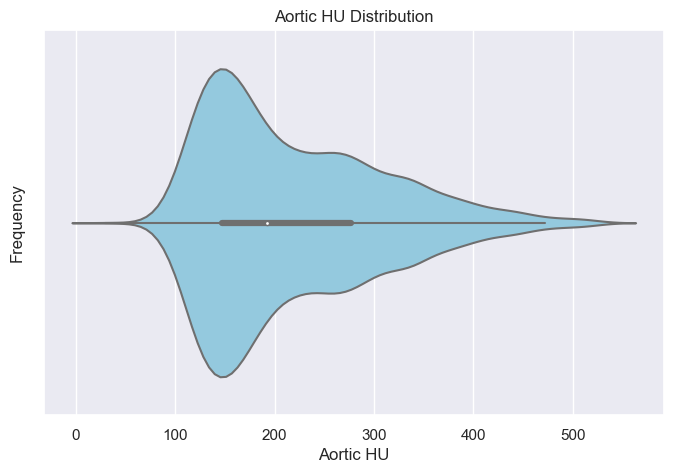

In [78]:
# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(8, 5))

# Create a violin plot
sns.violinplot(x='aortic_hu', data=train_series_meta_clean, ax=ax, color='skyblue')

# Set title and labels
ax.set_title('Aortic HU Distribution')
ax.set_xlabel('Aortic HU')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

## Train DICOM Tags

In [83]:
# !pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 626.1 kB/s eta 0:00:0000:0100:140.8 MB 600.9 kB/s eta 0:07:51
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=b8a3a2acdfabea0467e4a085469d83de2a128c109603231560c54697312b2f02
  Stored in directory: /Users/zhiyiho/Library/Caches/pip/wheels/91/46/99/63d32bd67d58f84faf258c1acf6bb563a73ff0ee4a106c8da2
Successfully built pyspark


In [111]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [104]:
# spark.stop()
spark = SparkSession.builder.appName('Kaggle').getOrCreate()
train_dicom_tags = spark.read.parquet('train_dicom_tags.parquet')
train_dicom_tags.show(5)

+-------------+----------+-------+-----------+-------------+--------------------+-------+-----------------------+--------------------+--------------+-----+---------+---------------+-------------------------+-------------------+--------------+----------------+------------+----+--------------------+---------------+--------------------+------------+--------------+--------------------+------------+-----------+--------------------------+----------------------+-------------------------+-----------------------+--------------------------+-------------------+--------------------+-----------+
|BitsAllocated|BitsStored|Columns|ContentDate|  ContentTime| FrameOfReferenceUID|HighBit|ImageOrientationPatient|ImagePositionPatient|InstanceNumber|  KVP|PatientID|PatientPosition|PhotometricInterpretation|PixelRepresentation|  PixelSpacing|RescaleIntercept|RescaleSlope|Rows|      SOPInstanceUID|SamplesPerPixel|   SeriesInstanceUID|SeriesNumber|SliceThickness|    StudyInstanceUID|WindowCenter|WindowWidth|F

In [106]:
# print the rows and columns of the pyspark dataframe
print(f'Number of rows: {train_dicom_tags.count()}')
print(f'Number of columns: {len(train_dicom_tags.columns)}')

Number of rows: 1510373
Number of columns: 35


In [108]:
summary = train_dicom_tags.describe()
summary.show()

+-------+-------------+------------------+------------------+-------------------+------------------+--------------------+------------------+-----------------------+--------------------+------------------+------------------+-----------------+---------------+-------------------------+-------------------+--------------------+------------------+------------+-----------------+--------------------+---------------+--------------------+------------------+------------------+--------------------+------------+-----------+--------------------------+----------------------+-------------------------+-----------------------+--------------------------+-------------------+--------------------+-----------+
|summary|BitsAllocated|        BitsStored|           Columns|        ContentDate|       ContentTime| FrameOfReferenceUID|           HighBit|ImageOrientationPatient|ImagePositionPatient|    InstanceNumber|               KVP|        PatientID|PatientPosition|PhotometricInterpretation|PixelRepresentation|

| Information | Column Names |
| -------- | ------- |
| Image Data | BitsAllocated, BitsStored, PixelSpacing, RescaleIntercept, RescaleSlope |
| Patient Data | PatientID, StudyInstanceUID |
| Image Property | Rows, Columns, SOPInstanceUID |
| Unique identifiers | SOPInstanceUID, SeriesInstanceUID, and StudyInstanceUID |
| Imaging Settings | KVP, WindowCenter, and WindowWidth |
| DICOM standard | FileMetaInformationVersion, ImplementationClassUID, and TransferSyntaxUID |
| DICOM Image Location | path |

| Attribute                  | Description                                                                                                  |
|---------------------------|--------------------------------------------------------------------------------------------------------------|
| `BitsStored`               | Mean bits of data stored per pixel: ~14.25                                                                    |
| `Columns`                  | Mean number of columns: ~515.33                                                                              |
| `InstanceNumber`           | Mean instance number: ~325.35                                                                                |
| `KVP`                      | Mean X-ray tube voltage: ~116.26                                                                             |
| `PatientPosition`          | Position of the patient during imaging (e.g., FFS for feet-first supine)                                    |
| `PixelSpacing`             | Arrays of pixel spacing values for the images                                                                |
| `SOPInstanceUID`           | Unique identifier for instances in DICOM                                                                     |
| `SeriesInstanceUID`        | Unique identifier for series in DICOM                                                                        |
| `StudyInstanceUID`         | Unique identifier for studies in DICOM                                                                       |
| `WindowCenter`             | Windowing setting for images' visual representation                                                         |
| `WindowWidth`              | Windowing setting for images' visual representation                                                         |
| `path`                     | DICOM image files                                                       |
| `TransferSyntaxUID`        | Indicates the transfer syntax used for encoding the images                                                  |


| SeriesInstanceUID | 1.2.123.12345.1.2.3.49954.41479 |
| --- | --- |
| 0 | ?|
| 1 | ?|
| 2 | ?|
| 3 | ?|
| 4 | ?|
| 5 | ?|
| 6 | ?|
| 7 | patient_id |
| 8 | series_id |

In [116]:
# print all unique values in each column

# for col_name in train_dicom_tags.columns:
#     unique_values = train_dicom_tags.select((col_name)).distinct().collect()
#     unique_values = [str(row[0]) for row in unique_values]
#     print(col_name, unique_values)
#     print(f'{col_name}: \t\t {unique_values}')

print(f'RescaleType: \t\t {train_dicom_tags.select("RescaleType").distinct().collect()}')
    

RescaleType: 		 [Row(RescaleType='nan'), Row(RescaleType='Houndsfield Unit'), Row(RescaleType='HU')]
